# <font  color = "#0093AF">Relaxation in complex sequences: RECRR</font>

A challenge in acquiring $R_{1\rho}$ relaxation rate constants is that coherent oscillation is present at the beginning of the $R_{1\rho}$ period, which distorts the signal decay. While we could wait until oscillation is subsided, we lose significant signal. The beginning of the relaxation period is also particularly important, because $R_{1\rho}$ relaxation is multiexponential. The initial slope of decay gives the averaged rate constant, which is what we would like to acquire. However, after time, the faster relaxing components have decayed more than the slower components, so that the slope no longer correctly represents the correct average.

Keeler et al. propose a solution to suppress oscillation at the beginning of the $R_{1\rho}$ period, referred to as the REfocused CSA Rotating-frame Relaxation experiment (RECRR). In this experiment, the spin-locks (CW$_{\pm x}$)  are switched 180$^\circ$ in phase, and $\pi$-pulses are inserted to invert the magnetization, as follows:$^1$ 

CW$_x$ $-$ $\pi_y$ $-$ CW$_x$ $-$ CW$_{-x}$ $-$ $\pi_{-y}$ $-$ CW$_{-x}$

The spin-locks each have an integer number of rotor periods.

We will investigate the RECRR here and compare its performance to the standard $R_{1\rho}$ experiment

[1] E.G. Keeler, K.J. Fritzsching, A.E. McDermott. [*J. Magn. Reson.*](https://doi.org/10.1016/j.jmr.2018.09.004), **2018**, 296, 130-137.

## Setup

In [4]:
# SETUP SLEEPY
import os
os.chdir('../../../')

In [5]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Build the system and Liouvillian

In [6]:
ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=16000,pwdavg=sl.PowderAvg(),n_gamma=50)
ex0.set_inter('dipole',i0=0,i1=1,delta=44000)
ex0.set_inter('CSA',i=0,delta=113,euler=[0,23*np.pi/180,0])
ex1=ex0.copy()
ex1.set_inter('dipole',i0=0,i1=1,delta=44000,euler=[0,15*np.pi/180,0])
ex1.set_inter('CSA',i=0,delta=113,euler=[[0,23*np.pi/180,0],[0,15*np.pi/180,0]])

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(tc=200e-6)

## Build the propagators and density matrices
We construct the simulation by building two sequences that contain the $y$ and $-y$ $\pi$-pulses (seqA,seqB), which are two rotor periods each, and then two sequences that contain the $x$ and $-x$ spin-locks (seqx,seqmx). From these, we can construct propagators, and multiply them in the correct order for each time step in the RECRR sequence. We may also use the $x$-propagator for the $R_{1\rho}$ experiment.

The density matrices for $R_{1\rho}$ (`R1p`) and RECRR (`RECRR`) sequences are also created below, including a basis set reduction for propagators and density matrices.

In [7]:
v1=25000
v1pi=60000
pi2=1/v1pi/2

seqx=L.Sequence().add_channel('15N',v1=v1)   #Spin-lock on xs
seqmx=L.Sequence().add_channel('15N',v1=v1,phase=np.pi) #Spin-lock on -x

t=[0,L.taur-pi2/2,L.taur+pi2/2,2*L.taur]
#First refocusing period
seqA=L.Sequence().add_channel('15N',t=t,v1=[v1,v1pi,v1],phase=[0,np.pi/2,0])
#Second refocusing period
seqB=L.Sequence().add_channel('15N',t=t,v1=[v1,v1pi,v1],phase=[np.pi,3*np.pi/2,np.pi])

R1p=sl.Rho('15Nx','15Nx')

R1p,seqx,seqmx,seqA,seqB=R1p.ReducedSetup(seqx,seqmx,seqA,seqB)
RECRR=R1p.copy_reduced()

State-space reduction: 32->16


Below, we plot components of the RECRR sequence. `seqx` and `seqmx` will be appended to these sequences to increase the spin-lock length by a total of four rotor periods at a time.

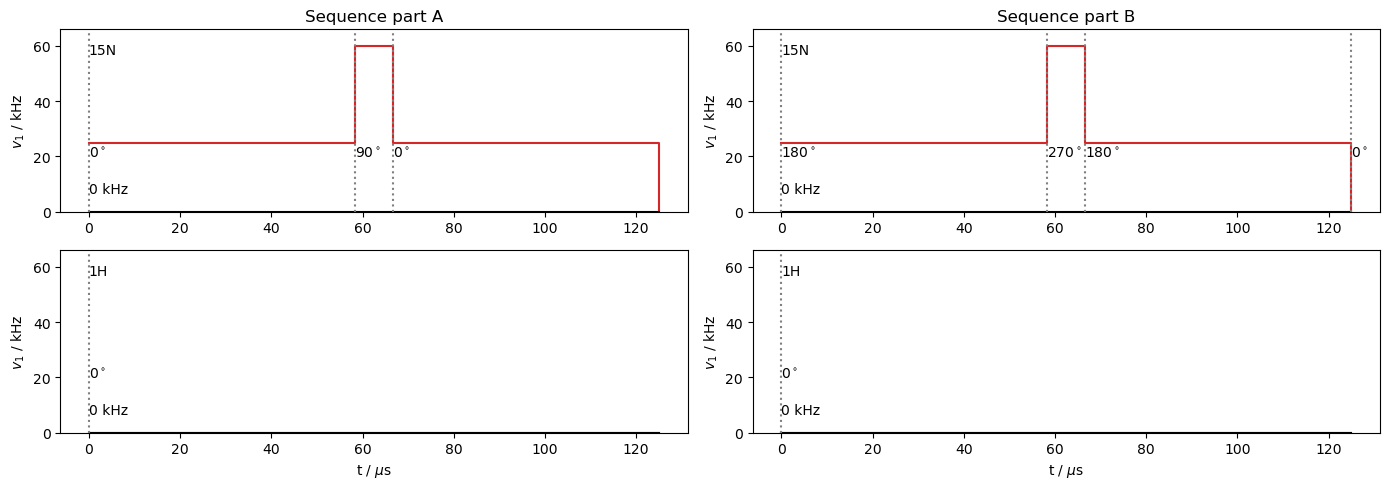

In [8]:
ax=plt.subplots(2,2,figsize=[14,5])[1].T
seqA.plot(ax=ax[0])
ax[0][0].set_title('Sequence part A')
seqB.plot(ax=ax[1])
ax[1][0].set_title('Sequence part B')
ax[0,0].figure.tight_layout()

## Propagation and plotting
We start with the standard $R_{1\rho}$ experiment

The basic $R_{1\rho}$ experiment only requires repetition of the `Ux` propagator, so we can simply use the `DetProp` function.

Note that we can extract the purely decaying (non-oscillating components) using the `extract_decay_rates` function of a density matrix object (`rho`). This is used to quantify the fraction of the signal that can be fitted to a decay curve, and also to construct a curve with purely decaying components (no oscillation), which we overlay with the total signal.

/Users/albertsmith/Documents/GitHub/SLEEPY/SLEEPY/Rho.py:633: UserWarning: Reduced Liouvillian applied to uninitialized rho. Make sure reduction was perfomed with same Rho
  warnings.warn('Reduced Liouvillian applied to uninitialized rho. Make sure reduction was perfomed with same Rho')


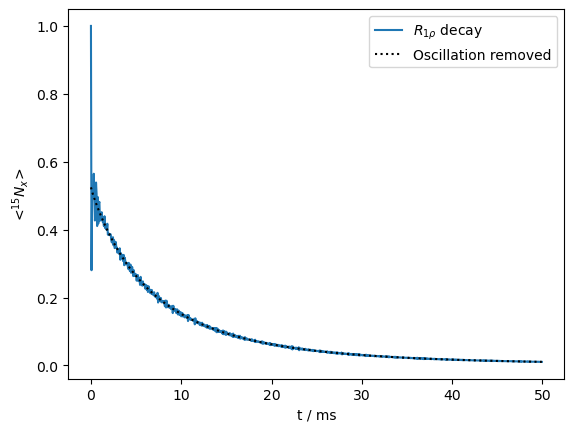

In [9]:
R1p.clear(data_only=True)
Ux=seqx.U()   #Propagator for R1p

#Extract decay rates and their corresponding weights
# Includes powder average weighting in 'wt_rates' mode
r1p,A=R1p.extract_decay_rates(Ux,mode='wt_rates') 

R1p.DetProp(Ux,n=800) #Propagate

#Build decay-only curve
I=np.sum([A0*np.exp(-r1p0*R1p.t_axis) for r1p0,A0 in zip(r1p,A)],axis=0)
sc=A.sum()

# Plotting
ax=R1p.plot()
ax.plot(R1p.t_axis*1e3,I,color='black',linestyle=':')
_=ax.legend((r'$R_{1\rho}$ decay','Oscillation removed'))

In [10]:
print(f'{sc*100:.0f}% of the signal is non-oscillating')

52% of the signal is non-oscillating


At the beginning of the decay, we observe a loss of almost half of the signal, due to coherent oscillation.

We also calculate the RECRR sequence. Since additional rotor periods must be inserted into each of four spin-lock blocks, we cannot use the `DetProp` function. We do accelerate the calculation by building up the $x$ and $-x$ spin locks at each loop step, instead of recalculating `Ux**k` and `Umx**k` at every step.

In [11]:
Ux=seqx.U()
Umx=seqmx.U()
UA=seqA.U()  #First half of sequence
UB=seqB.U() #Second half of sequence

RECRR()
for n in range(200):
    RECRR.reset()  #Reset density matrix
    UB*UA*RECRR    #Propagate by both first and second parts of sequence
    RECRR()        #Detect
    UA=Ux*UA*Ux    #Add 1 rotor period to each side of UA (x)
    UB=Umx*UB*Umx  #Add 1 rotor period to each side of UB (-x)

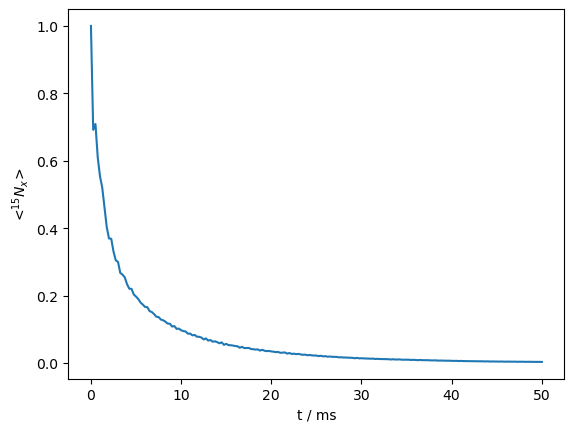

In [12]:
_=RECRR.plot()

Indeed, oscillations at the beginning of the decay curve have been almost entirely removed. However, it is worth noting that the decay rate at the beginning of the curve appears to be faster than with the standard $R_{1\rho}$ experiment. We overlay the two curves, scaling the RECRR curve to match the beginning of the non-coherent decay of the $R_{1\rho}$ curve.

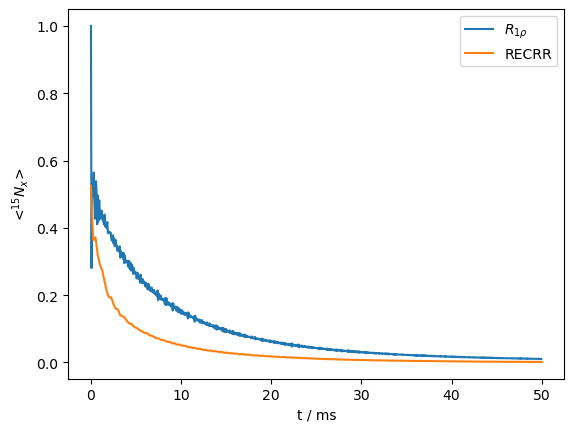

In [13]:
ax=R1p.plot()
ax.plot(RECRR.t_axis*1e3,RECRR.I[0].real*sc)
_=ax.legend((r'$R_{1\rho}$','RECRR'))

We clearly see that the RECRR curve is relaxing more quickly at the beginning.

We can investigate this effect based on analysis of a single orientation (single crystal), where the $R_{1\rho}$ experiment should be closer to monoexponential.

## Single crystal behavior
We simulate both sequences for a single crystal to better see the differences between the sequences. We sweep the correlation time and observe that at shorter correlation times, the relaxation behavior is very similar between the two sequences. However, at longer correlation times, a fast decaying component emerges in the RECRR that is not present in the standard $R_{1\rho}$ experiment. This is likely because the RECRR experiment relies on a refocusing of the CSA (and dipole) by cycling the phases, where if the frequency of the phase change matches the rate of motion, we interfere with this refocusing, and therefore obtain an additional relaxation mechanism that is not present in the $R_{1\rho}$ experiment. Since the frequency of the phase change is varying throughout the RECRR experiment, the timescale sensitivity is also varying depending on what time point in the RECRR experiment is currently being acquired.

We plot the $R_{1\rho}$ curves at the top, and RECRR curves at the bottom. We calculate the $R_{1\rho}$ decay without oscillation as well (dashed lines). This curve is overlayed over the RECRR curve with a scaling factor. We do this to show that the relaxation at longer times is very similar to the $R_{1\rho}$ behavior. For slower motion, it takes longer for the two curves to line up, since we are further into the sequence before the interference between motion and phase changes is fully mitigated.

/Users/albertsmith/Documents/GitHub/SLEEPY/SLEEPY/Rho.py:633: UserWarning: Reduced Liouvillian applied to uninitialized rho. Make sure reduction was perfomed with same Rho
  warnings.warn('Reduced Liouvillian applied to uninitialized rho. Make sure reduction was perfomed with same Rho')


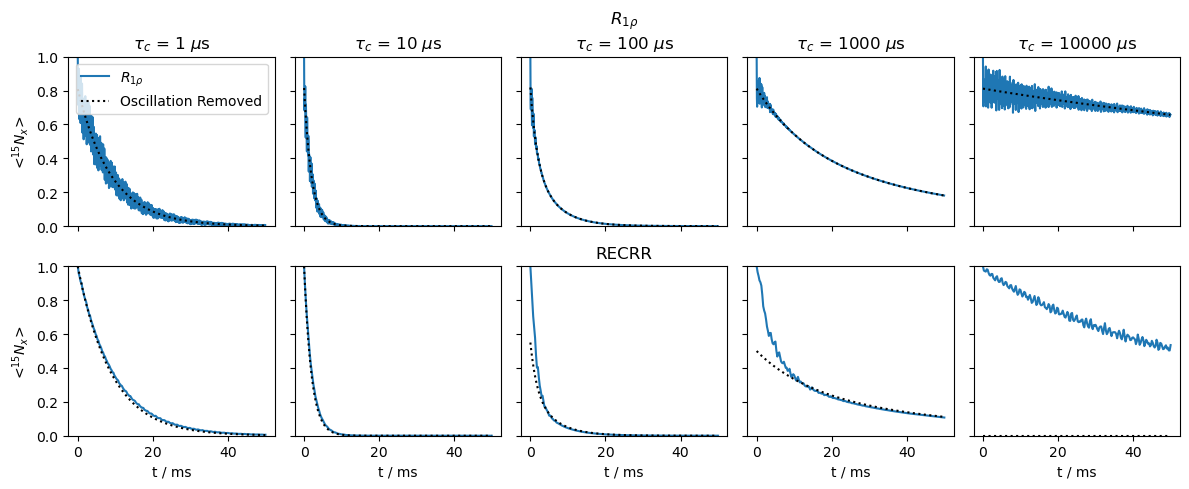

In [14]:
# Use just one orientation
# We generate the JCP59 powder average with q=2
# Indexing powder average returns single orientation
ex0.pwdavg=sl.PowderAvg(3)[10]

fig,ax0=plt.subplots(2,5,figsize=[12,5],sharex=True,sharey=True)
for tc,ax,sc in zip([1e-6,1e-5,1e-4,1e-3,1e-2],ax0.T,[1,1,.55,.5,0]):
    L.kex=sl.Tools.twoSite_kex(tc=tc)

    Ux=seqx.U()
    Umx=seqmx.U()
    UA=seqA.U()
    UB=seqB.U()

    R1p.clear()  #This keeps the Liouvillian in R1p
    #Without this, we would have to re-determine how R1p is block diagonal
    RECRR.clear()

    # R1p calculation
    r1p,A=R1p.extract_decay_rates(Ux,mode='rates')
    A,r1p=A[0],r1p[0]  #Index runs over the powder average, but we just have one element
    R1p.DetProp(Ux,n=800)

    R1p.plot(ax=ax[0])

    # Here we calculate the oscillation-free decay from R1p
    I=np.sum([A0*np.exp(-r1p0*R1p.t_axis) for r1p0,A0 in zip(r1p,A)],axis=0)

    ax[0].plot(R1p.t_axis*1e3,I,linestyle=':',color='black')
    ax[0].set_title(fr'$\tau_c$ = {tc*1e6:.0f} $\mu$s')
    
    # RECRR calculation
    RECRR()
    for k in range(200):
        RECRR.reset()
        (UB*UA*RECRR)()
        UA=Ux*UA*Ux
        UB=Umx*UB*Umx
    RECRR.plot(ax=ax[1])
    ax[1].plot(R1p.t_axis*1e3,I/I[0]*sc,linestyle=':',color='black')
    for a in ax:
        a.set_ylim([0,1])
        if not(a.is_first_col()):a.set_ylabel('')
        if not(a.is_last_row()):a.set_xlabel('')
ax0[0][2].set_title(r'$R_{1\rho}$'+'\n'+ax0[0][2].get_title())
ax0[1][2].set_title(r'RECRR')
fig.tight_layout()
_=ax0[0,0].legend((r'$R_{1\rho}$',r'Oscillation Removed'))

Then, while the RECRR pulse sequence presents some significant advantages over the $R_{1\rho}$ sequence, because of the more complex relaxation behavior, it becomes necessary to use simulation to fit the curves, rather than relying on simple mono-exponential or bi-exponential fitting. This is especially important at slower correlation times, where a second relaxation mechanism emerges, and the sensitivity of this experiment to correlation time varies throughout the duration of the experiment.